<a href="https://colab.research.google.com/github/mwortham94/2.156/blob/main/Classification_Demo_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.155/6 Classification Demo

<font size="1"> Created by L. Regenwetter in Sept 2021;
Updated by F. Ahmed and Lyle Regenwetter in Oct. 2022;
Updated by L. Regenwetter in Oct. 2023
</font>

Today, we will be testing several classifiers from a Machine Learning library called Scikit-learn (sklearn). Scikit-learn is well known for its intuitive syntax and ease of use. You can learn more about sklearn here: https://scikit-learn.org/stable/. We will also be using a package called Pandas to organize our data. Pandas specializes at organizing tabular data in "Dataframe" objects. Dataframes are tables with row and column labels, but Pandas has many built-in data manipulation functions that work efficiently on dataframes. Let us first import some packages.

In [ ]:
#Import Data processing packages
import pandas as pd
import numpy as np

#Import Data visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

#Normally we would import the relevant sklearn packages at the top but
#for this lab, we will be importing them as we use them for clarity.


#Binary Classification: Heat Exchanger Design

We will first consider a heat exchanger design problem. Two design variables (d_p and n_p) are given, and each heat exchanges is classified as constraint-satisfying or constraint-violating.

<img src="https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Classification/HX.png" height="400px">

The problem has several constraints on head loss, enclosure volume, and encloser length. Together, these combine to render certian designs invalid, while leaving others valid.

Let's load the data from Github

In [ ]:
url = 'https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Classification/solar_hex.parquet'
data = pd.read_parquet(url)

Let's take a look at the data:

In [ ]:
display(data)

,d_p,n_p,valid
0,0.079030,22.0,1
1,0.053862,30.0,1
2,0.036837,16.0,0
3,0.111663,39.0,0
4,0.095492,10.0,0
...,...,...,...
495,0.074280,34.0,1
496,0.070770,13.0,0
497,0.045114,36.0,0
498,0.044218,18.0,0


In [ ]:
x = data.loc[:,["d_p", "n_p"]]
y = data.loc[:,["valid"]]

Let's check the proportion of designs that are valid:

In [ ]:
print(f"Valid proportion: {np.sum(y.values)/len(y)}")

Valid proportion: 0.48


In [ ]:
# Importing necessary function and splitting the data into training and testing sets with 70% training and 30% testing
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3)

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
#Function to plot the ROC curve.


We will be recording four score metrics: accuracy, precision, recall, and F1. The Wikipedia page on ROC has an excellent overview of these various scores: https://en.wikipedia.org/wiki/Receiver_operating_characteristic. Luckily, these metrics are built into sklearn and we can import them! First, let us create a handy little scoring function.

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

Now we need some classifiers to test! We will test out logistic regression (a bit of a misnomer since it is a classifier!) and a Support Vector Classifier. First, we initialize our model, fit it on the training data, perform class predictions on the test data, then generate prediction probabilities for each data point in the test data. When we call model.fit, the model will "train," optimizing its weights to maximize the training objective, in this case, classification accuracy. We call decision_function on the trained model to get the classification confidence values for the test data. Then we call the function we defined earlier.

In [ ]:
from sklearn.linear_model import LogisticRegression
Log = LogisticRegression(solver='lbfgs')
Log.fit(xtrain, ytrain)
probabilities = Log.decision_function(xtest)
predictions = Log.predict(xtest)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


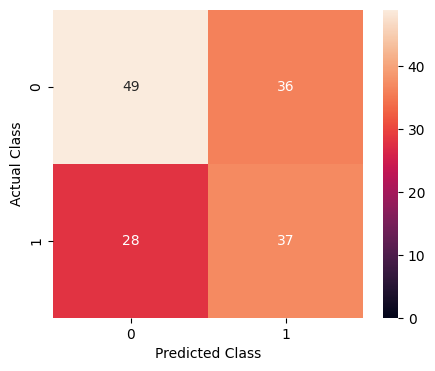

In [ ]:
#View the confusion matrix and the confusion matrix
def plot_confusion_matrix(predictions, actual):
    c = confusion_matrix(ytest, predictions)
    matdf = pd.DataFrame(c, index=[0,1], columns=[0,1])
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(ax=ax, data=matdf, vmin=0, annot=True, fmt='g')
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")

plot_confusion_matrix(predictions, ytest)

In [ ]:
#Calculate performance metrics
def calcscores(Ytest, predictions):
    score = np.zeros(4)
    score[0] = accuracy_score(Ytest, predictions)
    score[1] = recall_score(Ytest, predictions, average='macro', zero_division=0)
    score[2] = precision_score(Ytest, predictions, average='macro', zero_division=0)
    score[3] = f1_score(Ytest, predictions, average='macro')
    print("Accuracy: " + str(100 * score[0]) + "%")
    print("Recall: " + str(100 * score[1]) + "%")
    print("Precision: " + str(100 * score[2]) + "%")
    print("F1: " + str(100 * score[3]) + "%")
calcscores(ytest, predictions)

Accuracy: 57.333333333333336%
Recall: 57.28506787330316%
Precision: 57.16064757160648%
F1: 57.05850778314545%


We are going to use a metric called the Receiver Operating Characteristic (ROC). This curve shows the true positive rate (TPR aka recall) vs. the false positive rate (FPR aka fall-out). The plot is generated over a sweep of decision threshold values: i.e., the confidence threshold that the classifier must exceed for us to predict a road bike. Do we only predict a road bike when it is at least 100% confident? This corresponds to the far left of the plot, where we have 0 TPR and 0 FPR. Do we predict a road bike when it is at least 0% confident? This will be the far right with 100% TPR and FPR. In practice, we would select our confidence threshold depending on the application and even use this ROC curve to guide our decision. First, let us define a function to plot our ROC curve and calculate the Area Under the ROC Curve (AUC).

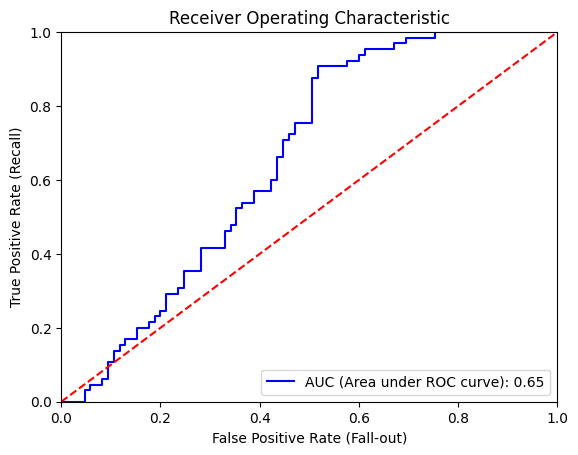

In [ ]:
#Plot the ROC curve and calculate AUC metric
def plotROC(Ytest_bin, Yscore):
    fpr, tpr, threshold = roc_curve(Ytest_bin, Yscore)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC (Area under ROC curve): %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate (Fall-out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend(loc = 'lower right')
    plt.show()

plotROC(ytest, probabilities)

Some classifiers provide probabilities rather than definite decisions, enabling us to plot a probability map. For instance, we can illustrate the probability function of our Logistic Regressor. Observing this, does the relatively low accuracy of our Logistic Regression make sense? Below, we define a function to plot decision boundaries:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


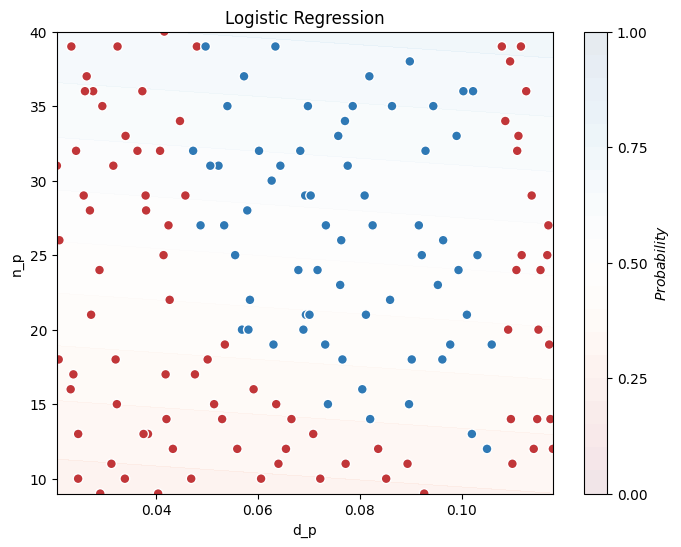

In [ ]:
# Define function to plot decision boundaries for classifiers
def plotDecisionBoundary(clf, name, xtest, ytest):
    xmin = np.min(xtest.values[:,0])
    xmax = np.max(xtest.values[:,0])
    ymin = np.min(xtest.values[:,1])
    ymax = np.max(xtest.values[:,1])

    # Create a mesh grid for the plot based on the feature values
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 1000), np.linspace(ymin, ymax, 1000))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict probability for each point in the mesh grid using the classifier
    Z = clf(grid)[:,1]
    Z = clf(grid)[:,1]
    Z = Z.reshape(xx.shape)
    f, ax = plt.subplots(figsize=(8, 6))
    levels = np.linspace(0,1,21)

    # Create contour plot to show the decision boundary
    contour = ax.contourf(xx, yy, Z, cmap="RdBu", alpha=0.1, levels=levels)
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), xlabel=x.columns[0], ylabel=x.columns[1])
    ax_c = f.colorbar(contour)
    ax_c.set_label("$Probability$")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    ax.scatter(xtest.values[:, 0], xtest.values[:, 1], c=ytest.values,
              s=50, cmap="RdBu", vmin=-0.2, vmax=1.2, edgecolor="white", linewidth=1)
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), xlabel=x.columns[0], ylabel=x.columns[1])
    ax.set_title(name)
    plt.show()

# Call the function with Logistic Regression classifier, passing the predict_proba method for probability predictions
plotDecisionBoundary(Log.predict_proba, "Logistic Regression", xtest, ytest)



Let's try a support vector classifier and a KNN classifier, two other classification methods.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 64.66666666666666%
Recall: 67.19457013574662%
Precision: 69.0%
F1: 64.30976430976432%


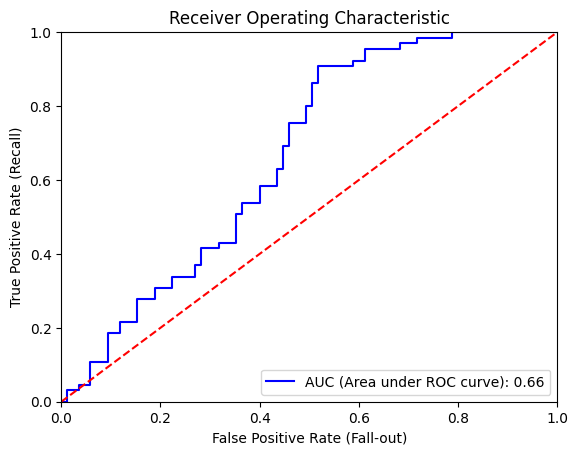

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


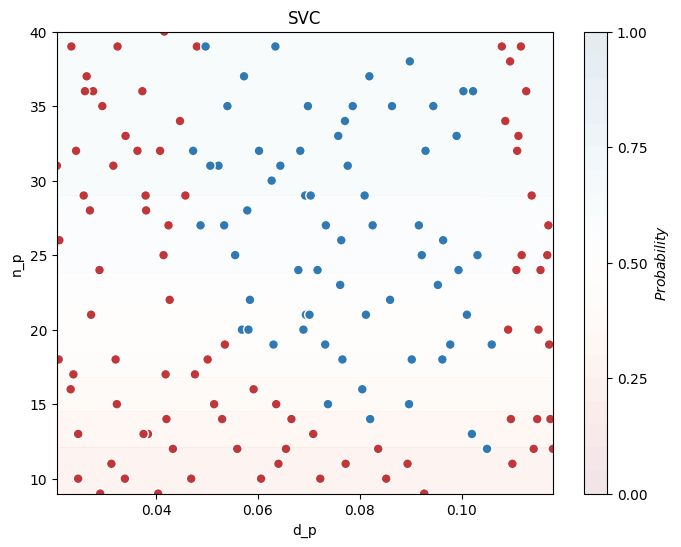

In [ ]:
from sklearn.svm import SVC
SVClf = SVC(probability=True)
SVClf.fit(xtrain, ytrain)
probabilities = SVClf.decision_function(xtest)
predictions = SVClf.predict(xtest)
calcscores(ytest, predictions)
plotROC(ytest, probabilities)
plotDecisionBoundary(SVClf.predict_proba, "SVC", xtest, ytest)

Next, lets try a decision tree classifier:

Accuracy: 98.0%
Recall: 98.05429864253395%
Precision: 97.8896103896104%
F1: 97.96738786756403%


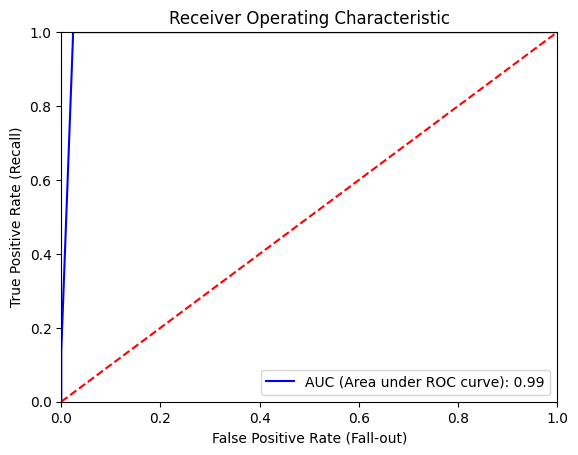

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


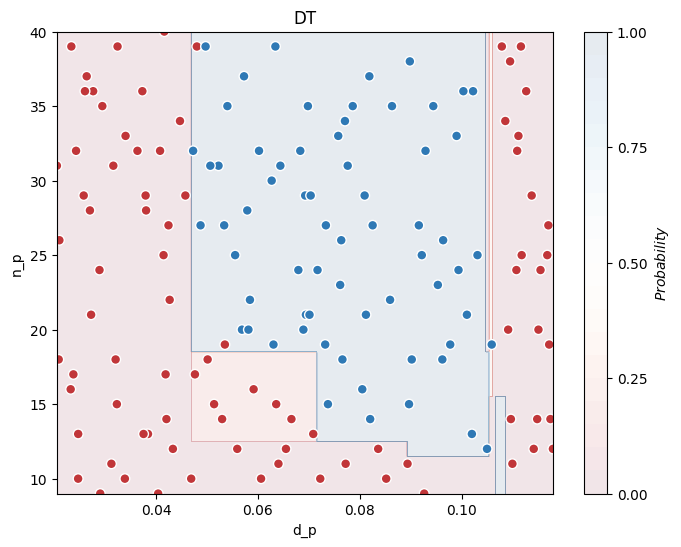

In [ ]:
from sklearn.tree import DecisionTreeClassifier

depth = 5
DT = DecisionTreeClassifier(max_depth=depth)
DT.fit(xtrain, ytrain)

# Get predicted probabilities and classes
probabilities = DT.predict_proba(xtest)[:,1]
predictions = DT.predict(xtest)

calcscores(ytest, predictions)
plotROC(ytest, probabilities)

# Plot decision boundaries
plotDecisionBoundary(DT.predict_proba, "DT", xtest, ytest)


Next, we'll try K-nearest neighbors

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 72.66666666666667%
Recall: 74.79638009049773%
Precision: 76.02583586626139%
F1: 72.56791114679513%


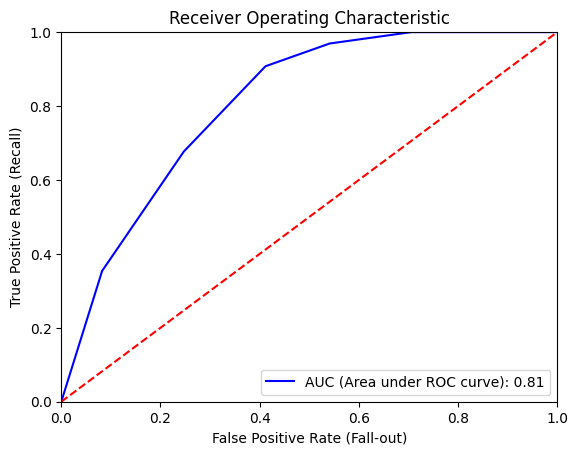

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


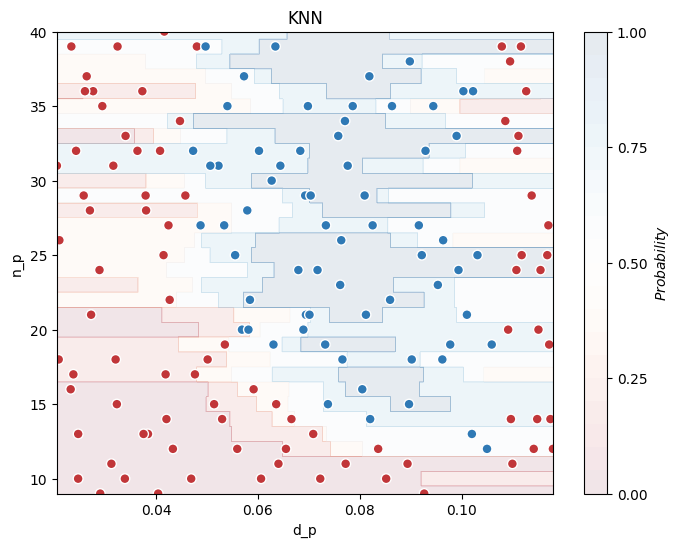

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Set number of neighbors
n_neighbors = 5

# Initialize and train classifier
KNN = KNeighborsClassifier(n_neighbors=n_neighbors)
KNN.fit(xtrain, ytrain)

# Get predicted probabilities and classes
probabilities = KNN.predict_proba(xtest)[:,1]
predictions = KNN.predict(xtest)

# Evaluate classifier
calcscores(ytest, predictions)
plotROC(ytest, probabilities)

# Plot decision boundaries
plotDecisionBoundary(KNN.predict_proba, "KNN", xtest, ytest)


**Question 1:** Why does the plot have long blue regions extending horizontally? Hint: Data scaling! How can you correct the problem? Does the predictor perform better?

Tip: scikit-learn has an [interface](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) to couple scalers and predictors. You can do something like the following:

```
Log = make_pipeline(StandardScaler(), LogisticRegression())
```



We can plot decision boundaries for SVM with a few different kernels, decision trees with different depths, as well as a K-Nearest-Neighbors Classifier with a few values of K.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


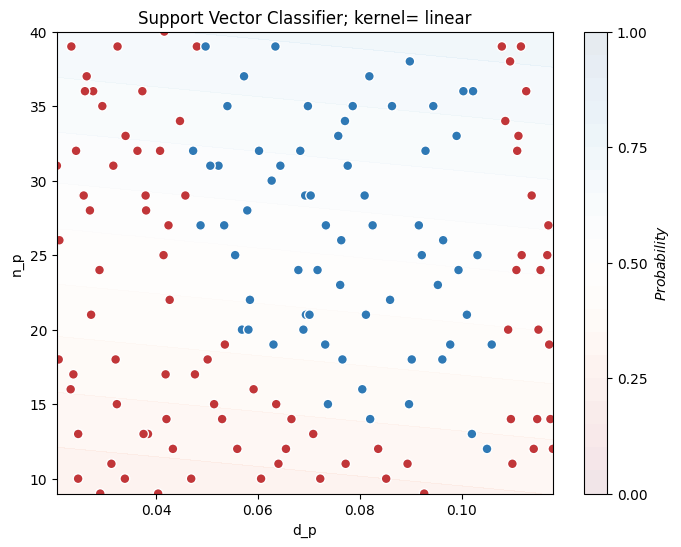

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


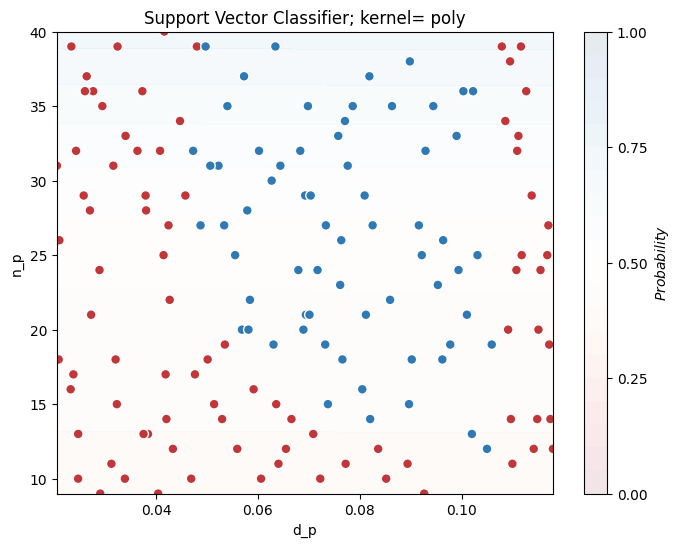

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


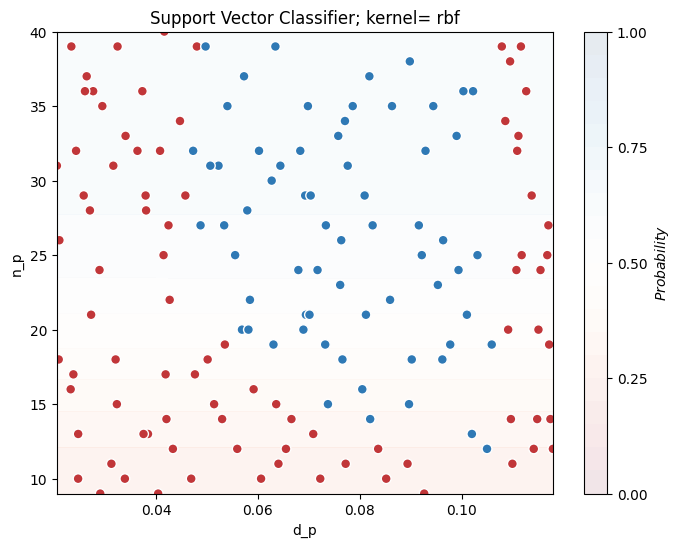

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


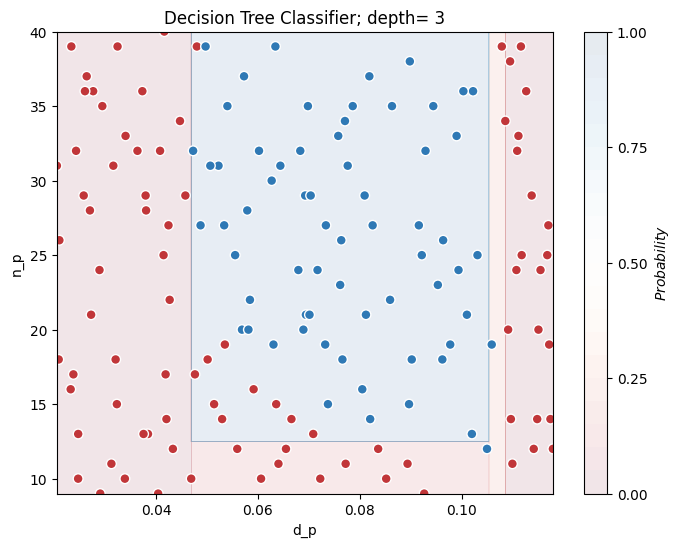

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


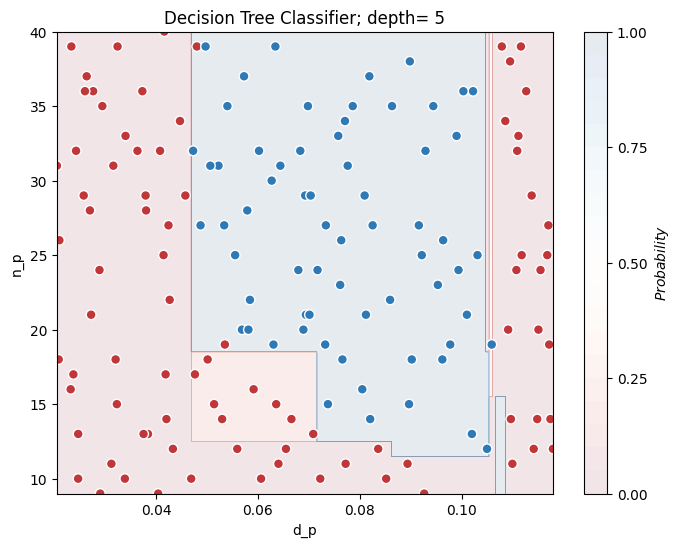

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


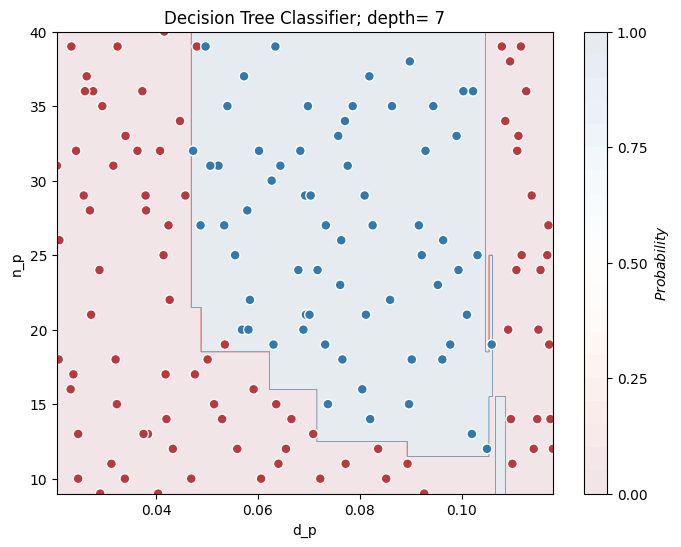

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


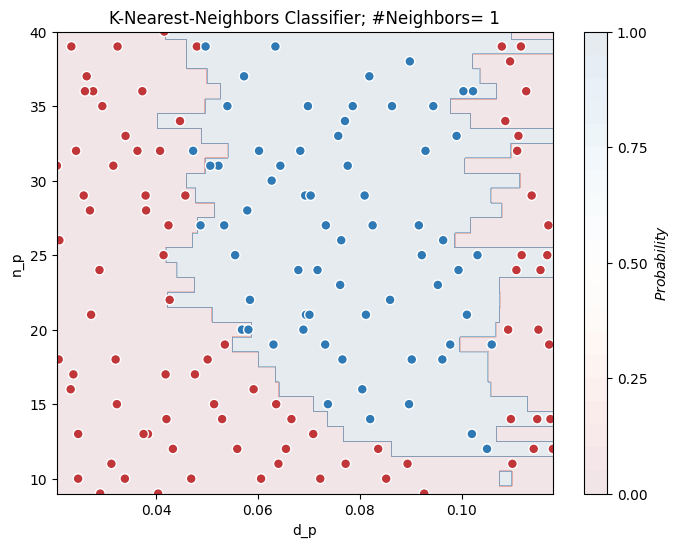

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


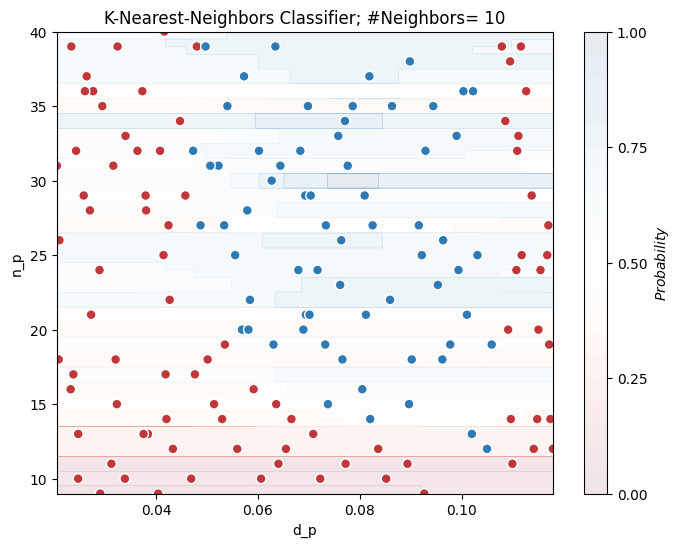

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


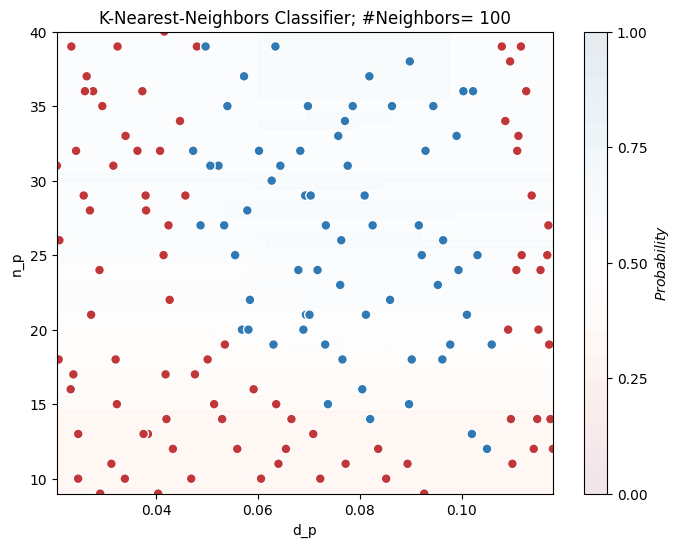

In [ ]:
for kernel in ["linear", "poly", "rbf"]:
    SVClf_test = SVC(kernel=kernel, probability=True)
    SVClf_test.fit(xtrain, ytrain)
    plotDecisionBoundary(SVClf_test.predict_proba, f"Support Vector Classifier; kernel= {kernel}", xtest, ytest)

for depth in [3,5,7]:
    DT_test = DecisionTreeClassifier(max_depth=depth)
    DT_test.fit(xtrain, ytrain)
    plotDecisionBoundary(DT_test.predict_proba, f"Decision Tree Classifier; depth= {depth}", xtest, ytest)

for k in [1,10,100]:
    KNN_test = KNeighborsClassifier(n_neighbors=k)
    KNN_test.fit(xtrain, ytrain)
    plotDecisionBoundary(KNN_test.predict_proba, f"K-Nearest-Neighbors Classifier; #Neighbors= {k}", xtest, ytest)

**Question 2:** Discuss the impact of hyperparameters on classification performance. What challenges arise when selecting them, and is this process straightforward? How would you approach hyperparameter selection?

## Multi-class classification: Bike Type Classification
Now let us move on to multi-class regression. We will be working with a bicycle classification problem from the BIKED dataset.

A bike can be labeled as a road bike, a mountain bike, a track bike, etc. Can you use machine learning to look at the features of a bike and predict what class it belongs to?

In this portion of the demo, we will be predicting the class of a bicycle using classification models. We are given a dataset of 4512 bikes. For each bike, we are given  features as well as a class label for each bike. Our goal is train a classifier on this data to be able to predict classes of previously unseen bike designs.

<img src="https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Classification/classifier.png" height="200px">

We have 20 different classes now instead of two. Furthermore, instead of two design variables, we now have 2401 variables (also known as features). Instead of working with predicted probabilities of each class, this time, we will just be taking the class that our models predict as most probable as the final output.

First, let's load up this dataset

In [ ]:
url = 'https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Classification/BIKED_processed.csv'
x = pd.read_csv(url, index_col=0)
url='https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Classification/Bikestyle.csv'
y = pd.read_csv(url, index_col=0)
display(x)
display(y)

,SSSIDECX3,SSSIDECX2,SSSIDECX1,SSSIDECY2,SSSIDECY1,STEMBENDS,FRONTROTORBOLTS,Shoe up angle,Down tube front diameter,LRTHICK,...,Top tube type OHCLASS: 0,Top tube type OHCLASS: 1,BRAZEonFDTYPE OHCLASS: FD9000F,BRAZEonFDTYPE OHCLASS: FD9070F,CSAUX3_MM_RATIO OHCLASS: 0,CSAUX3_MM_RATIO OHCLASS: 1,bottle SEATTUBE0 show OHCLASS: False,bottle SEATTUBE0 show OHCLASS: True,bottle DOWNTUBE0 show OHCLASS: False,bottle DOWNTUBE0 show OHCLASS: True
0,65.5,131.2,306.0,-10.0,10.0,0,6,36,42.0,10,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,65.5,104.1,242.9,-10.0,10.0,0,6,36,38.1,10,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,65.5,165.3,385.7,-10.0,10.0,0,6,35,32.0,10,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,65.5,132.3,308.6,-10.0,10.0,0,6,35,32.0,10,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,65.5,143.6,335.2,-10.0,10.0,0,6,36,38.1,10,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4507,58.8,117.7,274.6,-10.0,10.0,0,6,39,38.1,10,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4508,65.5,75.8,189.4,15.0,30.0,1,6,36,38.1,10,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4509,65.5,130.4,304.2,-10.0,10.0,1,6,39,38.1,10,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4510,88.9,177.7,10.3,-10.0,10.0,1,6,39,38.1,10,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


,BIKESTYLE
0,ROAD
1,DIRT_JUMP
2,POLO
3,ROAD
4,DIRT_JUMP
...,...
4507,COMMUTER
4508,MTB
4509,ROAD
4510,ROAD


This dataset is a bit more challenging than the last one! We now have an **overwhelming number of features** -- too many to manually interpret, so we are really relying on ML to understand the significance of each feature without any expert input. In addition, the bike classes provided (as noted in the paper) are **"noisy"** since they are subjectively self-classified by many different designers. In particular, a given bike design may reasonably be assigned to a variety of different classes.

Let's take a look at the class distribution

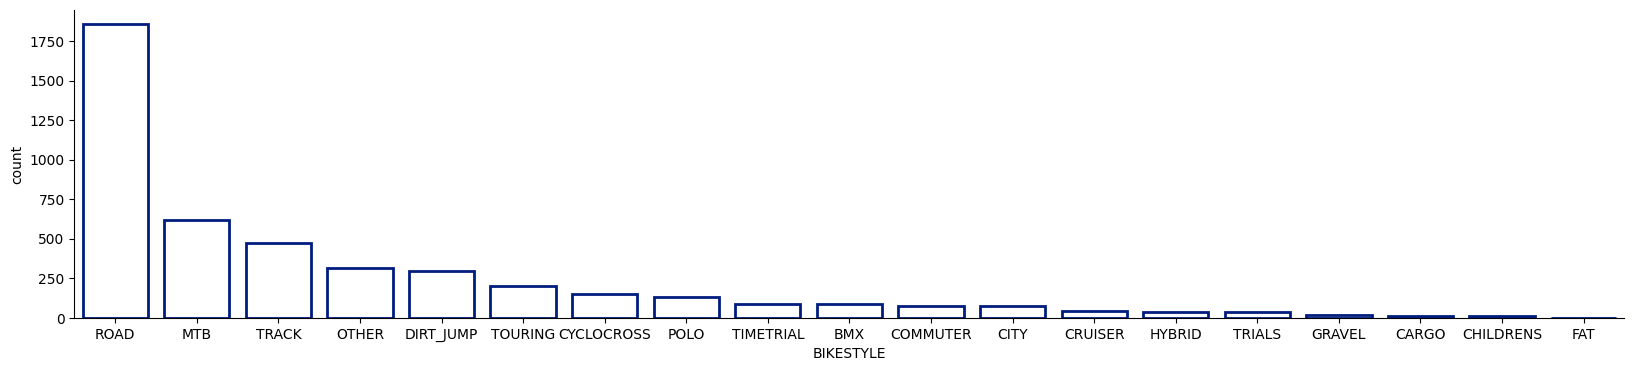

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
ax = sns.countplot(ax=ax, x="BIKESTYLE", data=y, order = y["BIKESTYLE"].value_counts().index, facecolor=(0, 0, 0, 0),
                   linewidth=2,
                   edgecolor=sns.color_palette("dark", 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

We split the data:

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y.values, train_size=3000, shuffle=True, random_state=2997)
Ytrain = np.squeeze(Ytrain)

Let us test out our Logistic Regression and SVC and throw in a few other methods for comparison: a simple decision tree, a random forest classifier, a gradient boosting classifier, and a neural network.

In [ ]:
from sklearn.linear_model import LogisticRegression
Log = LogisticRegression()

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

Log = make_pipeline(StandardScaler(), LogisticRegression())

Log.fit(Xtrain, Ytrain)

Log.score(Xtest, Ytest)

predictions = Log.predict(Xtest)




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Below, we try a set of classification algorithms and note their performance metrics.

In [ ]:
from sklearn.svm import SVC
SVClf = SVC()
SVClf.fit(Xtrain, Ytrain)
predictions = SVClf.predict(Xtest)
calcscores(Ytest,predictions)


Accuracy: 55.48941798941799%
Recall: 16.103570279788876%
Precision: 24.92880158255655%
F1: 16.213101700917797%


In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(max_depth=8)
DTC.fit(Xtrain, Ytrain)
predictions = DTC.predict(Xtest)
calcscores(Ytest,predictions)

Accuracy: 67.85714285714286%
Recall: 35.39849044323975%
Precision: 46.460537855848266%
F1: 37.07423225998806%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=8)
RF.fit(Xtrain, Ytrain)
predictions = RF.predict(Xtest)
calcscores(Ytest,predictions)

Accuracy: 69.9074074074074%
Recall: 29.121895578224372%
Precision: 58.4093217978433%
F1: 32.470885518671004%


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
RF = RandomForestClassifier(max_depth=7)
RF.fit(Xtrain, Ytrain)
predictions = RF.predict(Xtest)
calcscores(Ytest,predictions)

Accuracy: 68.32010582010582%
Recall: 27.345422357525038%
Precision: 50.72232960936513%
F1: 29.997017467808853%


We can see that many of our classifiers are achieving poor precision and even poorer recall, causing our F1 score to be abysmal, despite the higher accuracy scores. What is going on here? Let us use a confusion matrix to visualize the performance of one of our classifiers. We will visualize this confusion matrix using a heatmap. The heatmap tells us the distribution of classification decisions made by our model for every class in our dataset. A perfect confusion matrix (100% accuracy) would be a diagonal matrix. We will set up our matrix with actual classes on the y axis and predicted classes on the x axis. With this setup, the sum of values in every row should be one since we need the proportion of classification decisions to sum to 1.

Text(0.5, 47.7222222222222, 'Predicted Class')

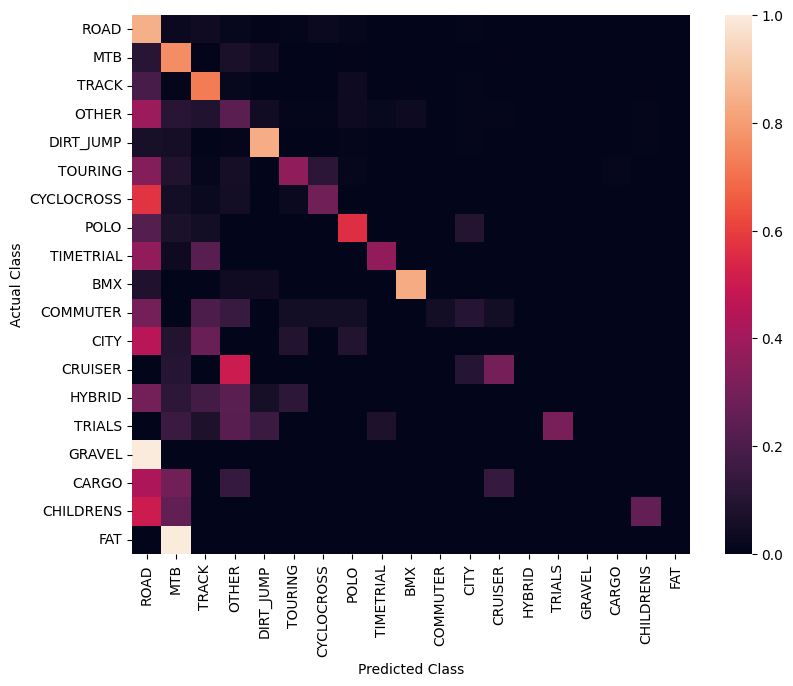

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = DTC.predict(Xtest)
classes = y["BIKESTYLE"].value_counts().index
mat = confusion_matrix(Ytest, predictions, labels=classes, sample_weight=None, normalize='true')
matdf = pd.DataFrame(mat, index=classes, columns=classes)
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(ax=ax, data=matdf)
# print(matdf.sum(axis=1)) Uncomment this to confirm that row sums are 1
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")

The ordering of classes on this heatmap is sorted by frequency. It looks like many of our bikes are being predicted as our more common classes, particularly road bikes, which constitute just over 40% of the samples. Can you figure out why this is? Recall that we determined our dataset was heavily unbalanced. Also, remember that our training objective is accuracy score.

Let's try weighting the importance of our classes. Let's try weighting samples according to the inverse of the number of samples of its class. This way, every class effectively has the same 'cumulative' weight. Mathematically, we express weights w in terms of class labels c as:

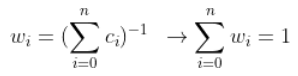

This is concisely expressed using the the "balanced" class weight option in many sklearn classifiers. We will manually implement this here instead of using the prebuilt method.

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

Ytraindf = pd.DataFrame(Ytrain, columns=["BIKESTYLE"])
counts = Ytraindf["BIKESTYLE"].value_counts(sort=False)
weights = counts.apply(lambda count: 1/count)
weight_dict = weights.to_dict()

# DTC = DecisionTreeClassifier(max_depth=8, class_weight="balanced")
DTC = DecisionTreeClassifier(max_depth=8, class_weight=weight_dict)
DTC.fit(Xtrain, Ytrain)
predictions = DTC.predict(Xtest)
calcscores(Ytest,predictions)

Accuracy: 26.851851851851855%
Recall: 29.60278868650668%
Precision: 43.81782229713279%
F1: 27.533064954309555%


It looks like this scaling was too aggressive. We not only diminished our accuracy, we actually worsened our other scores as well. Let's take a look at our new confusion matrix to see just how bad it looks.

Text(0.5, 47.7222222222222, 'Predicted Class')

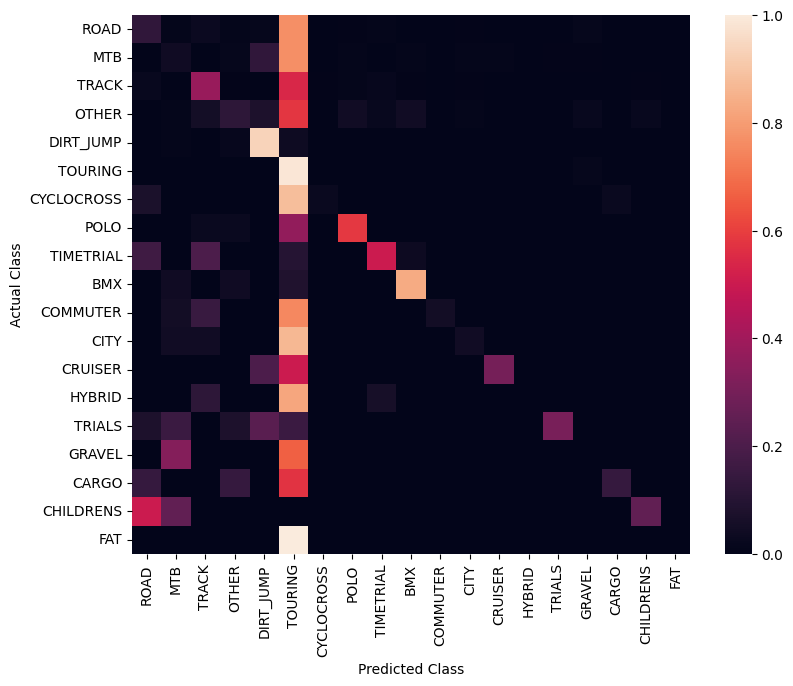

In [ ]:
predictions = DTC.predict(Xtest)
classes = y["BIKESTYLE"].value_counts().index
mat = confusion_matrix(Ytest, predictions, labels=classes, sample_weight=None, normalize='true')
matdf = pd.DataFrame(mat, index=classes, columns=classes)
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(ax=ax, data=matdf)
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")

This doesn't look great. Let's try to find a weighting that balances our various performance metrics. We leave this as an excercise. Fill in the '''Todo''' with your code. If you get stuck, you can reference the scaling function that we implemented.

**Question 3:** Question 3: Were you able to find a scaling that provided a balanced trade-off between accuracy and other performance metrics? Please elaborate.

Accuracy: 64.21957671957672%
Recall: 42.61669276662593%
Precision: 46.24097250707617%
F1: 41.81025424429022%


Text(0.5, 47.7222222222222, 'Predicted Class')

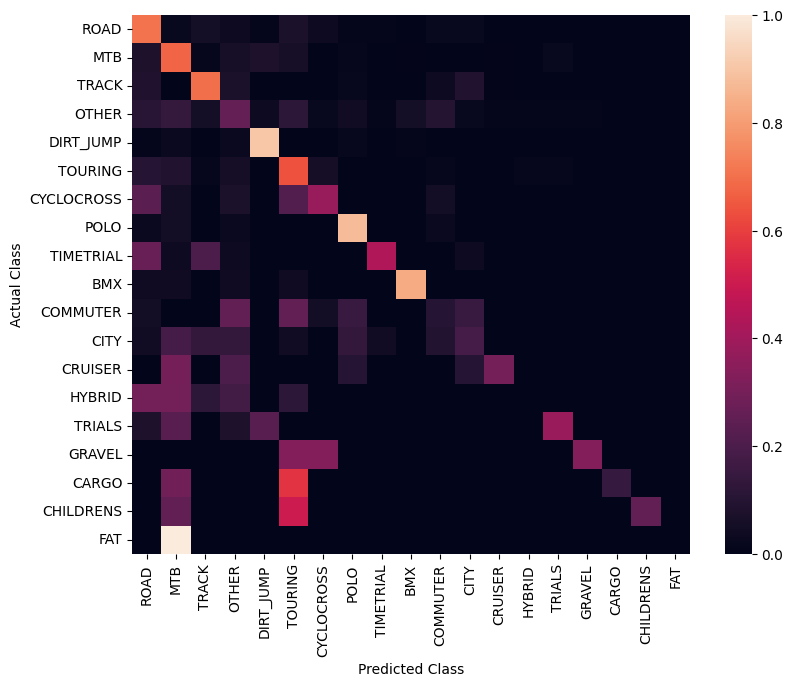

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight


Ytraindf = pd.DataFrame(Ytrain, columns=["BIKESTYLE"])
counts = Ytraindf["BIKESTYLE"].value_counts(sort=False)

#-----------------TODO---------------
weights = counts.apply(lambda count: 1/np.sqrt(count) ) #Lyle's scaling function - replace this with your own!
#------------------------------------

weight_dict = weights.to_dict()

# DTC = DecisionTreeClassifier(max_depth=8, class_weight="balanced")
DTC = DecisionTreeClassifier(max_depth=8, class_weight=weight_dict)
DTC.fit(Xtrain, Ytrain)
predictions = DTC.predict(Xtest)
calcscores(Ytest,predictions)

predictions = DTC.predict(Xtest)
classes = y["BIKESTYLE"].value_counts().index
mat = confusion_matrix(Ytest, predictions, labels=classes, sample_weight=None, normalize='true')
matdf = pd.DataFrame(mat, index=classes, columns=classes)
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(ax=ax, data=matdf)
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")

Hopefully you find a function that better balances our objectives. I tested weighting classes proportionally to the inverse of square root of class counts, which boosted F1 by 8% and only cost 3% accuracy.

Note: This sort of tuning of training parameters/objectives that we performed in this notebook is the exact reason why a validation dataset is necessary. If we perform too much tuning, we may be manually fitting to our test set, which we want to avoid! This is especially dangerous since we have no way to evaluate whether we are starting to fit to our test set if we validate using our test set!

The phenomenon is referred to as "data leakage." When you use the validation or test data to continually refine the model, it may perform well on these datasets but poorly on new, unseen data. This is because the model has become too specialized to the specific characteristics of the validation/test data, losing its ability to generalize well to new data.

**Demo reflection:** Revisit the demo and address the posed questions (1-3). Optionally, include a brief final analysis to highlight the central concepts. Demo reflection report is expected to be 1-2 pages in length.